## Contents
* Preprocessing
* Training The Model
* Visualizing The Model
* Predictions

In [16]:
import os
import pydotplus
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
from IPython.display import Image  

In [17]:
data_root = 'data'
train_file = os.path.join(data_root,'train.csv')
test_file = os.path.join(data_root,'test.csv')
test_label_file = os.path.join(data_root,'gender_submission.csv')

## Preprosessing

In [18]:
raw_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)
test_label = pd.read_csv(test_label_file)

In [19]:
raw_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [20]:
test_data.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [21]:
print('Null Number In Diffrent Columns : ')
test_data.isnull().sum()

Null Number In Diffrent Columns : 


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [22]:
print('Null Number In Diffrent Columns : ')
raw_data.isnull().sum()

Null Number In Diffrent Columns : 


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [23]:
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 
                    'Countess', 'Don', 'Jonkheer']
def substring_extractor(string,substrings) :
    for substring in substrings:
        
        if string.find(substring) != -1 :
            return substring
    return np.nan

def replace_titles(row):
    title = row['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if row['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

### Train Data

In [25]:
p_data = raw_data.loc[:]
p_data['Title'] = p_data['Name'].apply(lambda row:substring_extractor(row,title_list))
p_data['Title'] = p_data.apply(replace_titles,axis=1) # Reducing Titles
p_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


### Test Data

In [26]:
p_test_data = test_data.loc[:]
p_test_data['Title'] = p_test_data['Name'].apply(lambda row:substring_extractor(row,title_list))
p_test_data['Title'] = p_test_data.apply(replace_titles,axis=1) # Reducing Titles
p_test_data.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs


In [27]:
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
p_data['Deck']= p_data['Cabin'].fillna('Unknown').apply(lambda row: substring_extractor(row, cabin_list))

In [28]:
p_test_data['Deck']= p_test_data['Cabin'].fillna('Unknown').apply(lambda row: substring_extractor(row, cabin_list))

In [29]:
p_test_data.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
351,1243,2,"Stokes, Mr. Philip Joseph",male,25.0,0,0,F.C.C. 13540,10.5000,NaN,S,Mr,Unknown
31,923,2,"Jefferys, Mr. Clifford Thomas",male,24.0,2,0,C.A. 31029,31.5000,NaN,S,Mr,Unknown
346,1238,2,"Botsford, Mr. William Hull",male,26.0,0,0,237670,13.0000,NaN,S,Mr,Unknown
238,1130,2,"Hiltunen, Miss. Marta",female,18.0,1,1,250650,13.0000,NaN,S,Miss,Unknown
369,1261,2,"Pallas y Castello, Mr. Emilio",male,29.0,0,0,SC/PARIS 2147,13.8583,NaN,C,Mr,Unknown


In [30]:
p_data.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
683,684,0,3,"Goodwin, Mr. Charles Edward",male,14.0,5,2,CA 2144,46.9000,NaN,S,Mr,Unknown
866,867,1,2,"Duran y More, Miss. Asuncion",female,27.0,1,0,SC/PARIS 2149,13.8583,NaN,C,Miss,Unknown
543,544,1,2,"Beane, Mr. Edward",male,32.0,1,0,2908,26.0000,NaN,S,Mr,Unknown
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.2750,NaN,S,Miss,Unknown
830,831,1,3,"Yasbeck, Mrs. Antoni (Selini Alexander)",female,15.0,1,0,2659,14.4542,NaN,C,Mrs,Unknown


In [31]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
p_data['Age'] = imp.fit_transform(p_data['Age'].values.reshape(-1,1)).reshape(-1)
p_data = p_data.dropna()
target = p_data['Survived']
pp_data = p_data.drop(['Name','Ticket','Cabin','PassengerId','Survived'],axis=1)
print('Null Number In Diffrent Columns : ')
pp_data.isnull().sum()

Null Number In Diffrent Columns : 


Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Title       0
Deck        0
dtype: int64

In [32]:
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
p_test_data['Age'] = imp.fit_transform(p_test_data['Age'].values.reshape(-1,1)).reshape(-1)
p_test_data['Fare'] = imp.fit_transform(p_test_data['Fare'].values.reshape(-1,1)).reshape(-1)
pp_test_data = p_test_data.drop(['Name','Ticket','Cabin','PassengerId'],axis=1)
print('Null Number In Diffrent Columns : ')
pp_test_data.isnull().sum()

Null Number In Diffrent Columns : 


Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
Title       0
Deck        0
dtype: int64

In [33]:
pp_data.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck
1,1,female,38.0,1,0,71.2833,C,Mrs,C
3,1,female,35.0,1,0,53.1000,S,Mrs,C
6,1,male,54.0,0,0,51.8625,S,Mr,E
10,3,female,4.0,1,1,16.7000,S,Miss,G
11,1,female,58.0,0,0,26.5500,S,Miss,C


In [34]:
pp_test_data.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck
0,3,male,34.5,0,0,7.8292,Q,Mr,Unknown
1,3,female,47.0,1,0,7.0000,S,Mrs,Unknown
2,2,male,62.0,0,0,9.6875,Q,Mr,Unknown
3,3,male,27.0,0,0,8.6625,S,Mr,Unknown
4,3,female,22.0,1,1,12.2875,S,Mrs,Unknown


In [35]:
le = LabelEncoder()

pp_data['Sex'] = le.fit_transform(pp_data['Sex'])
pp_data['Embarked'] = le.fit_transform(pp_data['Embarked'])
pp_data['Title'] = le.fit_transform(pp_data['Title'])
pp_data['Deck'] = le.fit_transform(pp_data['Deck'])

In [36]:
pp_test_data['Sex'] = le.fit_transform(pp_test_data['Sex'])
pp_test_data['Embarked'] = le.fit_transform(pp_test_data['Embarked'])
pp_test_data['Title'] = le.fit_transform(pp_test_data['Title'])
pp_test_data['Deck'] = le.fit_transform(pp_test_data['Deck'])

In [37]:
pp_data.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck
1,1,0,38.0,1,0,71.2833,0,3,2
3,1,0,35.0,1,0,53.1000,2,3,2
6,1,1,54.0,0,0,51.8625,2,2,4
10,3,0,4.0,1,1,16.7000,2,1,6
11,1,0,58.0,0,0,26.5500,2,1,2


In [38]:
pp_test_data.head(5)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Deck
0,3,1,34.5,0,0,7.8292,1,2,7
1,3,0,47.0,1,0,7.0000,2,3,7
2,2,1,62.0,0,0,9.6875,1,2,7
3,3,1,27.0,0,0,8.6625,2,2,7
4,3,0,22.0,1,1,12.2875,2,3,7


## Training The Model

In [40]:
dtree = DecisionTreeClassifier()
model = dtree.fit(pp_data,target)

## Visualizing The Model

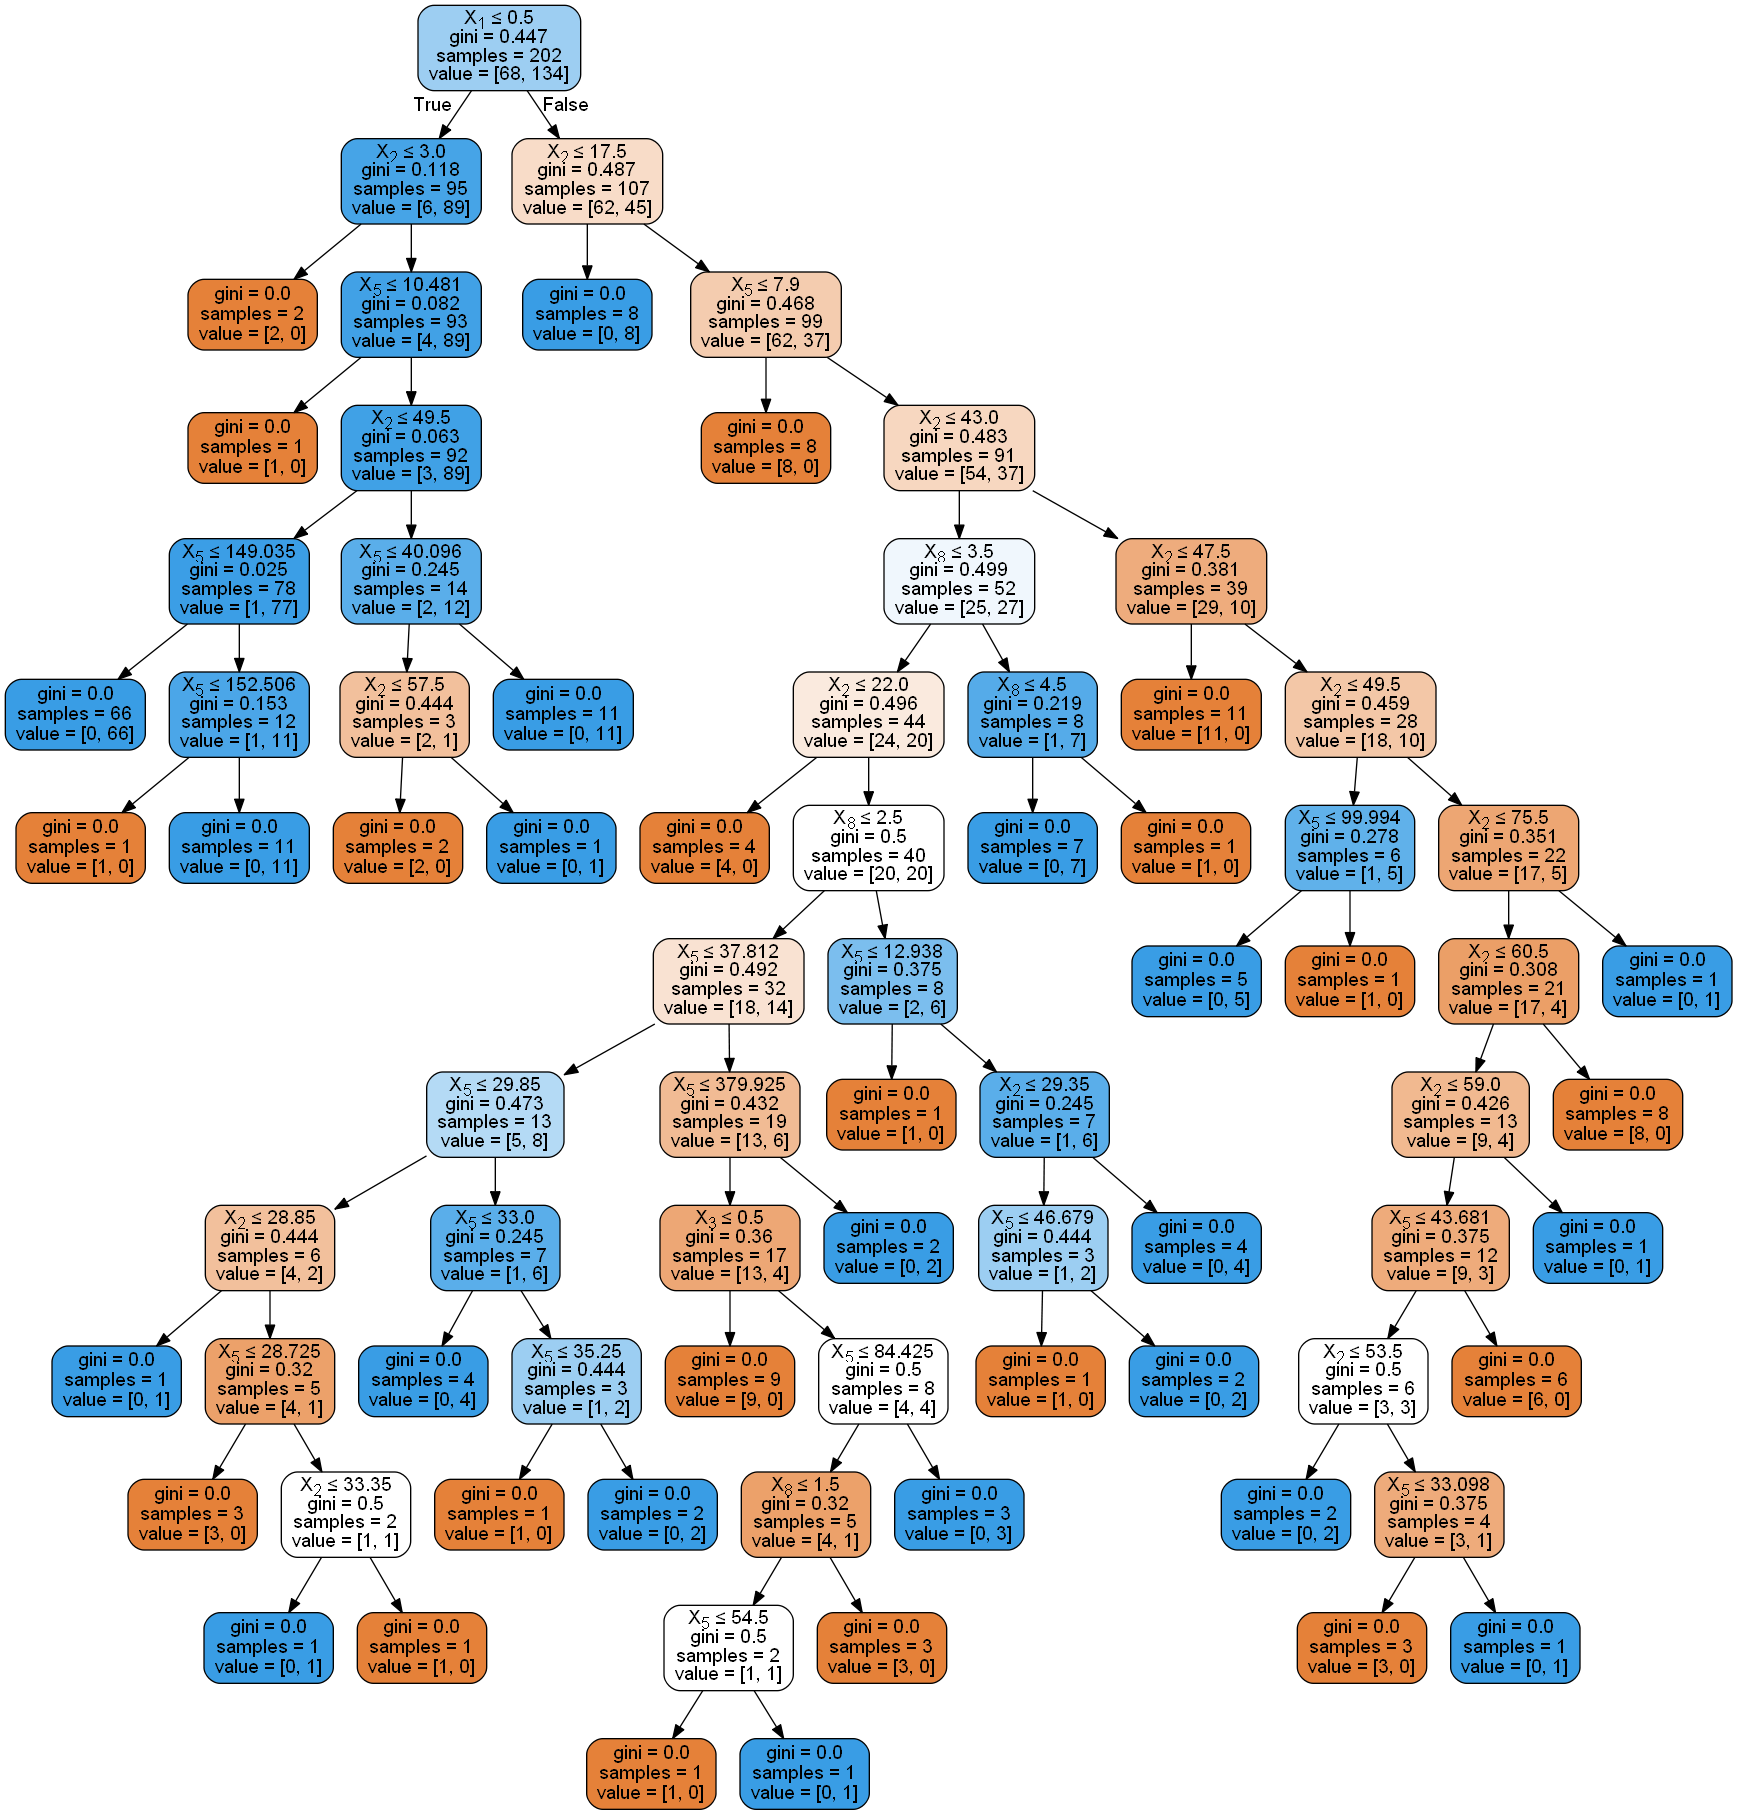

In [41]:
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

## Prediction

In [48]:
print('Accuracy On Train Set : %{}'.format(sum(model.predict(pp_data) == target)*100/len(target)))

Accuracy On Train Set : %100.0


In [47]:
print('Accuracy On Test Set : %{}'.format(sum(model.predict(pp_test_data) == test_label['Survived'])*100/len(test_label)))

Accuracy On Test Set : %76.79425837320574
